In [1]:
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os
import numpy as np

from Utils import loader, loss
from Train import train
from Model import Model

In [2]:
#imdir_rs19 = '/home/physik/Dokumente/rs19/jpgs/rs19_val'
#maskdir_rs19 = '/home/physik/Dokumente/rs19/uint8/rs19_val'
imdir_rs19 = '/home/luis/Documents/ImSeg/rs19_val/jpgs/rs19_val'
maskdir_rs19 = '/home/luis/Documents/ImSeg/rs19_val/uint8/rs19_val'
classes_ = {"rail-track","tram-track"}#,"rail-raised","rail-embedded"}
range_train = (0,4999)
range_test = (5000,7499)
range_val = (7500,8499)
img_size = (1024,512)

In [3]:
traindata = loader.dataset(imdir=imdir_rs19,
                      maskdir=maskdir_rs19,
                      numstart=range_train[0],
                      numend=range_train[1],
                      classes=classes_,
                      img_size = img_size)

testdata = loader.dataset(imdir=imdir_rs19,
                      maskdir=maskdir_rs19,
                      numstart=range_test[0],
                      numend=range_test[1],
                      classes=classes_,
                      img_size = img_size)

valdata = loader.dataset(imdir=imdir_rs19,
                      maskdir=maskdir_rs19,
                      numstart=range_val[0],
                      numend=range_val[1],
                      classes=classes_,
                      img_size = img_size)

In [4]:
#model_path = "/home/physik/Model_19122022_2"
model_path = "/home/luis/Documents/HSD_ARBEIT/Model_19122022_2"

In [5]:
model = Model.UNet(num_classes=3,p_dropout=0.3)

In [6]:
#model = model.to('cuda')

In [7]:
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

In [8]:
lossf=loss.BCEDiceLoss(lambda_dice=0.4,lambda_bce=0.6)

In [9]:
from Attacks import attacks

In [72]:
perturbed_testimg = attacks.I_FGSM_singleImage(model,
                         lossf,
                         valdata[44][0],
                         valdata[6][1],
                         0.0003,500)

In [63]:
#perturbed_testimg = attacks.I_FGSMLeastLikely_singleImage(model,
#                         lossf,
#                         valdata[38][0],
#                         3,
#                         0.005,500)

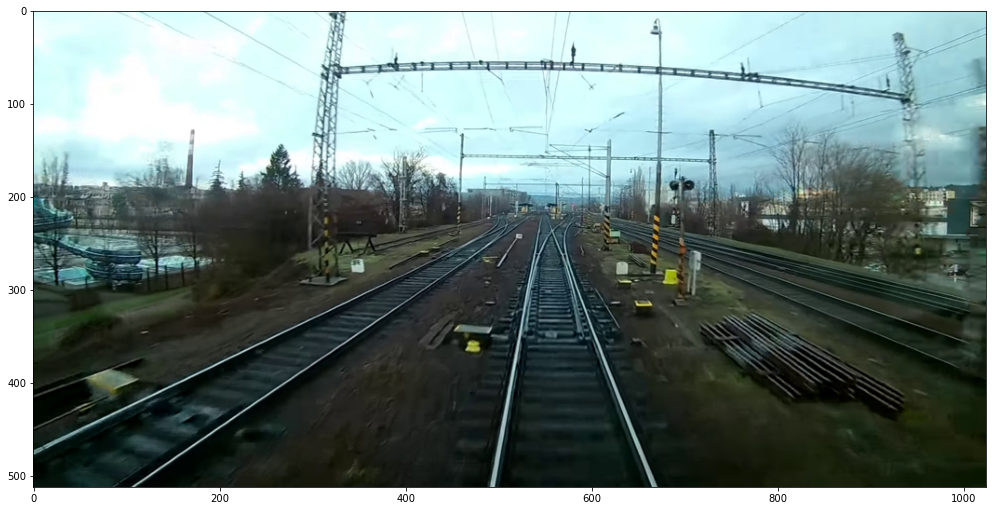

In [73]:
fig = plt.figure(figsize=(512/30,1024/30))
plt.imshow(valdata[44][0].cpu().detach().numpy().transpose(1,2,0))
plt.show()

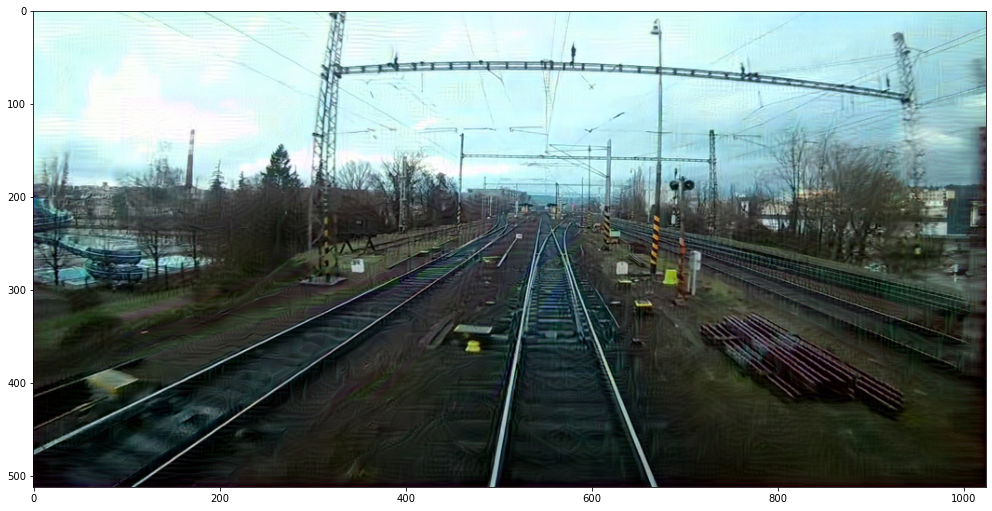

In [74]:
fig = plt.figure(figsize=(512/30,1024/30))
plt.imshow(perturbed_testimg[0][0].cpu().detach().numpy().transpose(1,2,0))
plt.show()

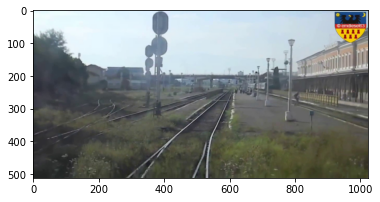

In [75]:
plt.imshow(valdata[6][0].cpu().detach().numpy().transpose(1,2,0))

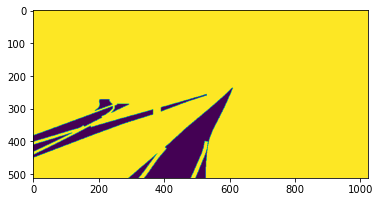

In [76]:
plt.imshow(valdata[6][1][2].cpu().detach().numpy())

In [77]:
d_device = 'cuda' if torch.cuda.is_available() else 'cpu'
prediction = model.predict(valdata[44][0].unsqueeze(0).to(d_device))

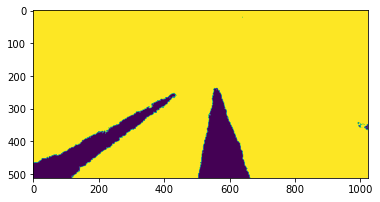

In [78]:
plt.imshow(prediction[1][0][2].cpu().detach().numpy())

In [79]:
prediction_adv = model.predict(perturbed_testimg[0].to(d_device))

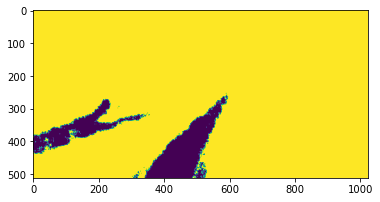

In [80]:
plt.imshow(prediction_adv[1][0][2].cpu().detach().numpy())